# **Installation of Essential Libraries**

In [2]:
import os
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
!pip install keras 
from tensorflow.keras import models,layers
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.applications import *
from tensorflow.keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.mobilenet_v3 import preprocess_input 

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

# Setup File Structure

In [3]:
# Load the dataset from a CSV file
data = pd.read_csv('/kaggle/input/multichannel-glaucoma-benchmark-dataset/metadata - standardized.csv', index_col=None)

# Setup Dataframes

In [4]:
# Load the dataset again to avoid an accidental overwrite
data = pd.read_csv('/kaggle/input/multichannel-glaucoma-benchmark-dataset/metadata - standardized.csv', index_col=None)

In [5]:
# Function to append '.png' extension to file names
def append_ext(fn):
    return fn+".png"

# Select a subset of the dataset where 'fundus' column is not null and not equal to -1
fundus_subset = data[(data['fundus'].notnull()) & (data['fundus'] != -1)]

# Select only the relevant columns for further processing
fundus_subset = fundus_subset[['types', 'fundus', 'names']]

# Create a new column 'combined' by applying the 'append_ext' function to 'names' column
fundus_subset['combined'] = fundus_subset['names'].apply(append_ext)

# Convert 'fundus', 'types' columns to strings for further processing
fundus_subset['fundus'] = fundus_subset['fundus'].astype(str)
fundus_subset['types'] = fundus_subset['types'].astype(str)

In [6]:
# glaucoma fundus images
glaucomaCount = len(fundus_subset[(fundus_subset['types'] == '1')])
print(glaucomaCount)

# healthy fundus images
healthyCount = len(fundus_subset[(fundus_subset['types'] == '0')])
print(healthyCount)

# Randomize the data to create balanced training, validation, and testing sets
fundus_subset_random = fundus_subset.sample(frac=1, random_state=1)

# Separate the randomized data into a dataframe of healthy and glaucoma subsets
healthy_subset = fundus_subset_random[fundus_subset_random['types'] == '0']
glaucoma_subset = fundus_subset_random[fundus_subset_random['types'] == '1']

testSize = 500
valSize = 500
# get train items
healthy_train = healthy_subset.head(healthyCount - testSize - valSize)
glaucoma_train = glaucoma_subset.head(glaucomaCount - valSize)
train = healthy_train.append(glaucoma_train)

# get val items
healthy_val = healthy_subset.tail(valSize)
glaucoma_val = glaucoma_subset.tail(valSize)
val = healthy_val.append(glaucoma_val)

# get test items
healthy_test = healthy_subset.tail(testSize)
glaucoma_test = glaucoma_subset.tail(testSize)
test = healthy_test.append(glaucoma_test)

4767
7549


/tmp/ipykernel_28/3072101087.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train = healthy_train.append(glaucoma_train)
/tmp/ipykernel_28/3072101087.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  val = healthy_val.append(glaucoma_val)
/tmp/ipykernel_28/3072101087.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test = healthy_test.append(glaucoma_test)


In [7]:
print("Train Size: ", len(train))
print("Val Size: ", len(val))
print("Test Size: ", len(test))

Train Size:  10816
Val Size:  1000
Test Size:  1000


# Generate Data Batches for Training, Validation, and Testing


In [8]:
# Set target size and batch size for data generator
target = 224
batchSize = 8

# Set the class mode to 'binary' for training data generator
classes = 'binary'

# Create the training data generator
trainDataGen = ImageDataGenerator(preprocessing_function=preprocess_input)
trainGen = trainDataGen.flow_from_dataframe(dataframe=train, 
                                            directory='/kaggle/input/multichannel-glaucoma-benchmark-dataset/full-fundus/full-fundus', 
                                            class_mode = classes,
                                            batch_size = batchSize, 
                                            shuffle=True, 
                                            x_col="combined", 
                                            y_col="types", 
                                            validate_filenames=True, 
                                            target_size=(target, target), 
                                            color_mode='rgb')


# Create the validation data generator
valDataGen = ImageDataGenerator(preprocessing_function=preprocess_input)
valGen = valDataGen.flow_from_dataframe(dataframe=val,
                                           directory='/kaggle/input/multichannel-glaucoma-benchmark-dataset/full-fundus/full-fundus',   
                                           batch_size = batchSize, 
                                           class_mode = classes,
                                           shuffle=False, 
                                           x_col="combined", 
                                           y_col="types", 
                                           validate_filenames=True, 
                                           target_size=(target, target), 
                                           color_mode='rgb')


# Create the testing data generator
testDataGen = ImageDataGenerator(preprocessing_function=preprocess_input)
testGen = testDataGen.flow_from_dataframe(dataframe=test,
                                           directory='/kaggle/input/multichannel-glaucoma-benchmark-dataset/full-fundus/full-fundus',   
                                           batch_size = batchSize, 
                                           class_mode = classes,
                                           shuffle=False, 
                                           x_col="combined", 
                                           y_col="types", 
                                           validate_filenames=True, 
                                           target_size=(target, target), 
                                           color_mode='rgb')

Found 10816 validated image filenames belonging to 2 classes.
Found 1000 validated image filenames belonging to 2 classes.
Found 1000 validated image filenames belonging to 2 classes.


# Generate Data Batches for Healthy_Subset and Glaucoma_Subset so it can be Visualized 


In [9]:

# Set class mode to 'sparse' for visualization data generators
classes = 'sparse'

# Create data generators for healthy and glaucoma subsets for visualization
healthy_subsetDataGen = ImageDataGenerator(preprocessing_function=preprocess_input)
healthy_subset_Gen = trainDataGen.flow_from_dataframe(dataframe=healthy_subset, 
                                            directory='/kaggle/input/multichannel-glaucoma-benchmark-dataset/full-fundus/full-fundus', 
                                            class_mode = classes,
                                            batch_size = batchSize, 
                                            shuffle=True, 
                                            x_col="combined", 
                                            y_col="types", 
                                            validate_filenames=True, 
                                            target_size=(target, target), 
                                            color_mode='rgb')


glaucoma_subsetDataGen = ImageDataGenerator(preprocessing_function=preprocess_input)
glaucoma_subset_Gen = glaucoma_subsetDataGen.flow_from_dataframe(dataframe=glaucoma_subset, 
                                            directory='/kaggle/input/multichannel-glaucoma-benchmark-dataset/full-fundus/full-fundus', 
                                            class_mode = classes,
                                            batch_size = batchSize, 
                                            shuffle=True, 
                                            x_col="combined", 
                                            y_col="types", 
                                            validate_filenames=True, 
                                            target_size=(target, target), 
                                            color_mode='rgb')


Found 7549 validated image filenames belonging to 1 classes.
Found 4767 validated image filenames belonging to 1 classes.


In [10]:
def show_images(gen):
    '''
    This function take the data generator and show sample of the images
    '''

    # return classes , images to be displayed
    g_dict = gen.class_indices        # defines dictionary {'class': index}
    classes = list(g_dict.keys())     # defines list of dictionary's kays (classes), classes names : string
    images, labels = next(gen)        # get a batch size samples from the generator

    # calculate number of displayed samples
    length = len(labels)        # length of batch size
    sample = min(length, 25)    # check if sample less than 25 images

    plt.figure(figsize= (20, 20))

    for i in range(sample):
        plt.subplot(5, 5, i + 1)
        image = images[i] / 255       # scales data to range (0 - 255)
        plt.imshow(image)
        index = np.argmax(labels[i])  # get image index
        class_name = classes[index]   # get class of image
        plt.title(class_name, color= 'blue', fontsize= 12)
        plt.axis('off')
    plt.show()

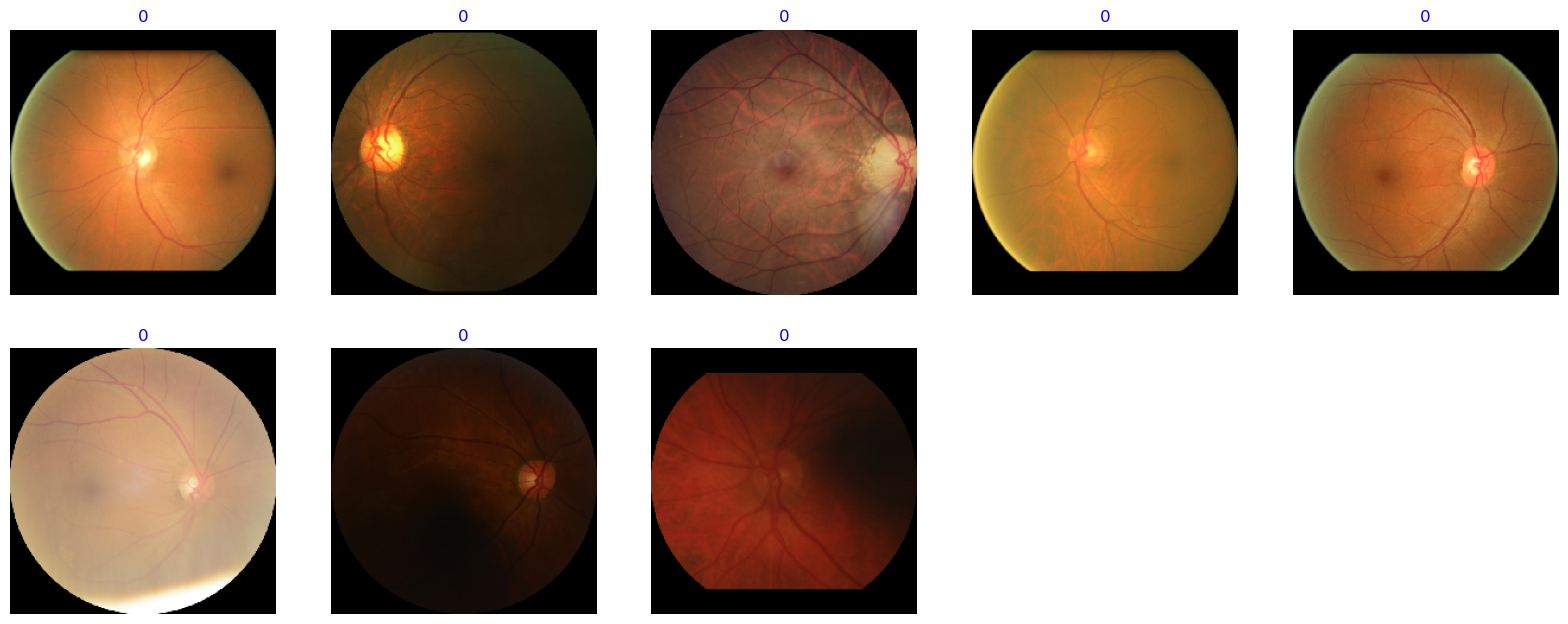

In [11]:
show_images(healthy_subset_Gen)

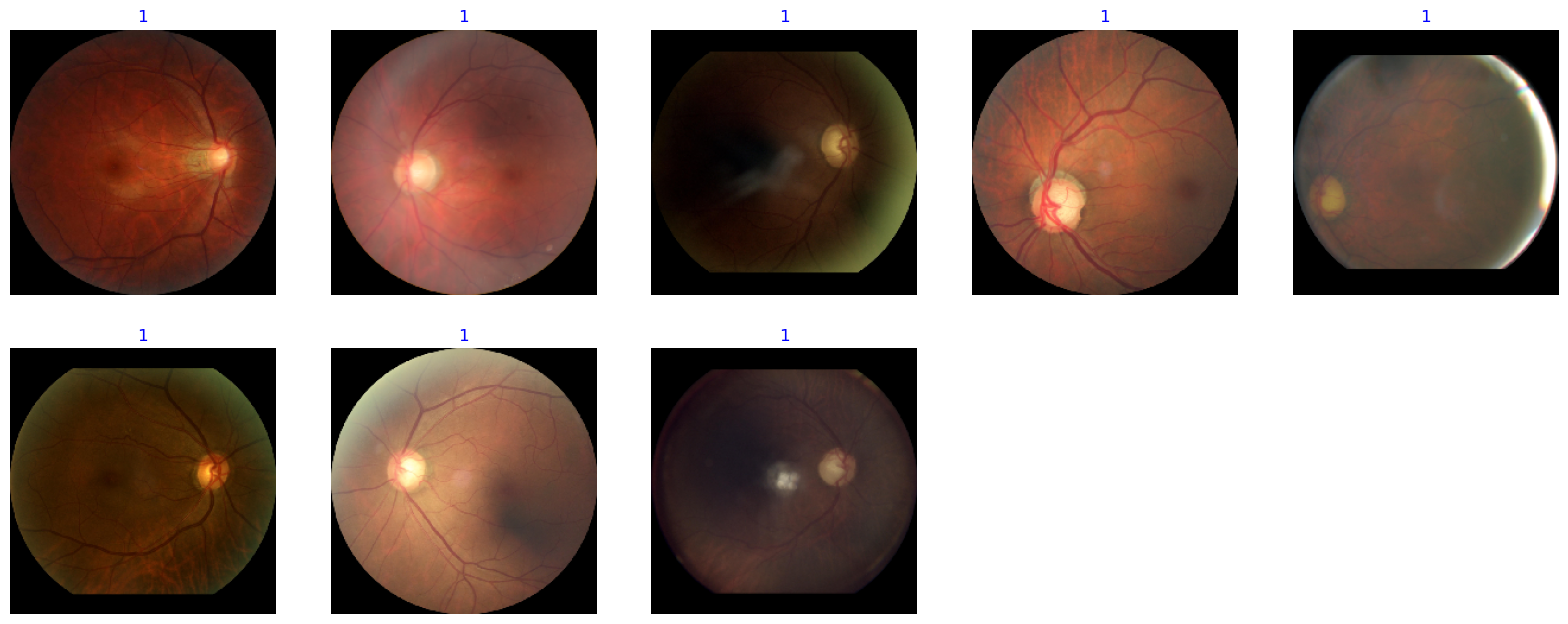

In [12]:
show_images(glaucoma_subset_Gen)

# Create Baseline Model using MobileNetV3-Large, and Compile the Model 

In [13]:
# Load MobileNetV2 as the base model and set layers to be non-trainable
base_for_model = tf.keras.applications.MobileNetV2(weights='imagenet', input_shape=(224,224,3), include_top=False)
for layer in base_for_model.layers:
    layer.trainable = False

9406464/9406464 [==============================] - 0s 0us/step


In [14]:
# Build the custom model on top of the MobileNetV2 base
model = Sequential()
model.add(base_for_model) 
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(512, activation='relu'))
model.add(GlobalMaxPooling2D()) 
model.add(BatchNormalization())
model.add(Dense(512, activation = 'relu')) 
model.add(BatchNormalization()) 
model.add(Dense(512,activation='relu'))
model.add(BatchNormalization())
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 dense (Dense)               (None, 7, 7, 512)         655872    
                                                                 
 batch_normalization (BatchN  (None, 7, 7, 512)        2048      
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 7, 7, 512)         262656    
                                                                 
 global_max_pooling2d (Globa  (None, 512)              0         
 lMaxPooling2D)                                                  
                                                        

In [15]:
# Define the F1 score metric
def f1_score_metric(y_true, y_pred):
    y_pred = tf.round(y_pred)
    return 2 * tf.reduce_sum(y_true * y_pred) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + tf.keras.backend.epsilon())


In [16]:
# Compile the model
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=['accuracy','Precision','Recall','AUC',f1_score_metric]
)

In [17]:
# Train the model
history=model.fit(
    trainGen,
    epochs=10,
    batch_size=64,
    validation_data=valGen
)

Epoch 1/10
1352/1352 [==============================] - 200s 137ms/step - loss: 0.6426 - accuracy: 0.6821 - precision: 0.6138 - recall: 0.5240 - auc: 0.7082 - f1_score_metric: 0.5446 - val_loss: 0.6274 - val_accuracy: 0.6710 - val_precision: 0.7450 - val_recall: 0.5200 - val_auc: 0.7814 - val_f1_score_metric: 0.3351
Epoch 2/10
1352/1352 [==============================] - 120s 89ms/step - loss: 0.5566 - accuracy: 0.7304 - precision: 0.6949 - recall: 0.5643 - auc: 0.7676 - f1_score_metric: 0.6034 - val_loss: 0.5155 - val_accuracy: 0.7240 - val_precision: 0.7947 - val_recall: 0.6040 - val_auc: 0.8292 - val_f1_score_metric: 0.3705
Epoch 3/10
1352/1352 [==============================] - 119s 88ms/step - loss: 0.5365 - accuracy: 0.7428 - precision: 0.7167 - recall: 0.5756 - auc: 0.7836 - f1_score_metric: 0.6171 - val_loss: 0.5583 - val_accuracy: 0.7020 - val_precision: 0.8435 - val_recall: 0.4960 - val_auc: 0.8296 - val_f1_score_metric: 0.3231
Epoch 4/10
1352/1352 [==========================

In [18]:
# Evaluate the model on the validation data
score=model.evaluate(valGen)
score

125/125 [==============================] - 10s 80ms/step - loss: 0.4897 - accuracy: 0.7610 - precision: 0.8115 - recall: 0.6800 - auc: 0.8624 - f1_score_metric: 0.4003


[0.48966580629348755,
 0.7609999775886536,
 0.8114558458328247,
 0.6800000071525574,
 0.8624060153961182,
 0.40029361844062805]

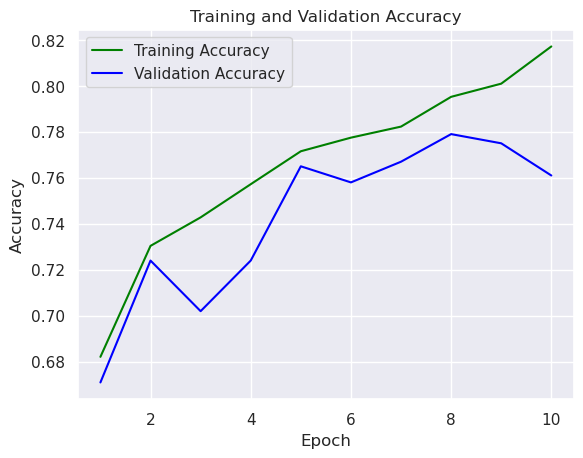

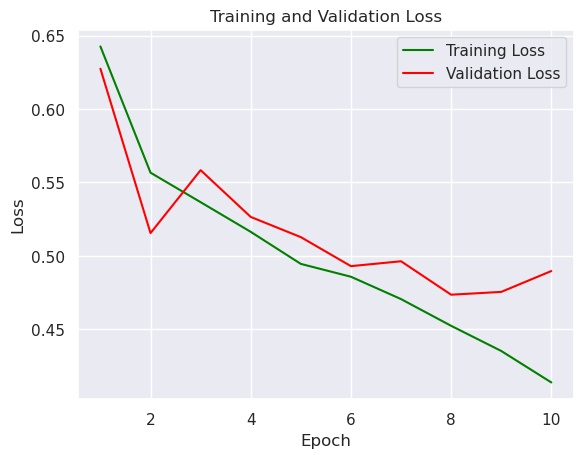

In [19]:
# Plot the training and validation accuracy and loss
import seaborn as sns
sns.set()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

#accuracy plot
plt.plot(epochs, acc, color='green', label='Training Accuracy')
plt.plot(epochs, val_acc, color='blue', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.figure()
#loss plot
plt.plot(epochs, loss, color='green', label='Training Loss')
plt.plot(epochs, val_loss, color='red', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()